In [2]:
import json


import sys
sys.path.append('../')
from extraction_pipeline.job_post_extraction_pipeline import JobPostSkillExtractor
import numpy as np
import pandas as pd
from scipy import linalg
import re 
from sklearn.cluster import KMeans
from sklearn import cluster
import sklearn
import matplotlib.pyplot as plt


### Read dobie output

In [3]:
with open('data/skills.json') as json_file:
    skills = json.load(json_file)
    # for p in skills:
    #     print(p)


extractor = JobPostSkillExtractor()
job_posts = extractor.get_job_posts()

### Create job posts - skills Matrix

In [51]:
A = np.zeros((len(job_posts), len(skills)))


In [52]:
def camel_case_split(str): 
    return re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', str) 

In [351]:
for c in camel_case_split('JavaScript'):
    print(c)

Java
Script


In [360]:
idx = 0
skill_index_dict = {}
for s in skills:
    skl = s['string']
    skill_index_dict[skl] = idx
    idx_arr = pd.Index(job_posts.requirements).str.contains(skl, regex=False)

    if np.all(idx_arr == False):
        skls = camel_case_split(skl)

        idx_arr = pd.Index(job_posts.requirements).str.contains(skl[0], regex=False) & (pd.Index(job_posts.requirements).str.contains(skl[1], regex=False))
        print(idx_arr)
        print(np.all(idx_arr == False))
    
    A[idx_arr, idx] = 1
    idx += 1

col_sums = np.sum(A,axis=0)
print(col_sums.shape)


[False  True  True ... False False False]
False
[ True  True  True ...  True False  True]
False
[ True  True  True ...  True False  True]
False
[False False False ...  True  True  True]
False
[ True  True  True ...  True False  True]
False
[ True  True  True ... False False  True]
False
[ True  True False ... False  True  True]
False
[ True  True  True ...  True False  True]
False
[False  True False ...  True False False]
False
[ True  True  True ...  True False  True]
False
[ True  True  True ...  True False  True]
False
[ True  True False ... False  True  True]
False
[ True  True  True ...  True False  True]
False
[ True  True  True ...  True False  True]
False
(95,)


In [54]:
print(A)
print(A.shape)

[[0. 0. 1. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 0. 1.]
 [0. 1. 1. ... 1. 0. 1.]
 ...
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]]
(1777, 95)


###  Filter out job posts with none of the identified skills and skills that are common to more than 500 job posts

In [55]:
zero_rows = np.where(np.sum(A, axis=1)==0)[0]

In [56]:
A_reduced = A[np.sum(A, axis=1)>0]
A_reduced.shape

reduced_skill_indices = np.where(np.sum(A_reduced, axis=0)<500)[0]

A_reduced2 = A_reduced[:,(np.sum(A_reduced, axis=0)<500)]
print(A_reduced2.shape)
print(reduced_skill_indices)

(1568, 79)
[ 0  3  4  5  6  7  8  9 14 15 17 19 20 21 22 24 25 26 27 28 29 30 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 53 54 55 56 57 58
 59 60 61 62 63 64 65 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 84
 85 86 88 89 91 92 93]


In [57]:
def find_max_silhouette_K(X, min_k=2, max_k=16):
    silhouette_score_values=list()

    NumberOfClusters=range(min_k, max_k)

    for i in NumberOfClusters:

        classifier=cluster.KMeans(i,init='k-means++', random_state=0)
        classifier.fit(X)
        labels= classifier.predict(X)
        silhouette_score_values.append(sklearn.metrics.silhouette_score(X,labels ,metric='euclidean', sample_size=None, random_state=None))
 
    Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
    plt.plot(NumberOfClusters, silhouette_score_values)
    plt.title("Silhouette score values vs Numbers of Clusters ")
    plt.show()
    return(Optimal_NumberOf_Components)

In [144]:
def run_K_means(X, n_clusters, reduced_skill_indices=reduced_skill_indices):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    labels = kmeans.labels_
    print(np.bincount(labels))

    centroids = kmeans.cluster_centers_

    for c in centroids:
        print(np.sort(-c[c>0.1]))
        for sk in np.argsort(-c)[0:16]:
            print(skills[reduced_skill_indices[sk]]['string'])
    return centroids, labels

### Find optimal number of clusters using silhouette score and run recursive k-means if needed

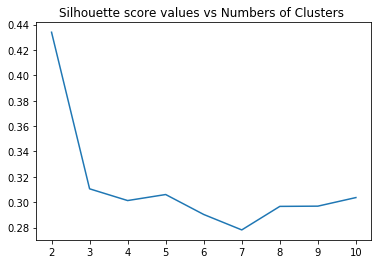

[1520   48]
[-0.25986842 -0.25723684 -0.18355263 -0.17434211 -0.15986842 -0.15
 -0.14473684 -0.14342105 -0.13355263 -0.13026316 -0.10657895 -0.10460526]
SQL
Java
Git
Design
REST
HTML
CSS
Linux
API
UI
JavaScript
Developer
React
Python
HTML5
UX
[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -0.97916667 -0.97916667 -0.97916667 -0.97916667 -0.97916667
 -0.97916667 -0.97916667 -0.97916667 -0.97916667]
Docker
Jenkins
Gradle
Cassandra
Maven
Python
Git
Ruby
Scala
NoSQL
Ansible
Kafka
SQL
Akka
Development
DevOps
0 0.9693877551020408 0.25986842105263175


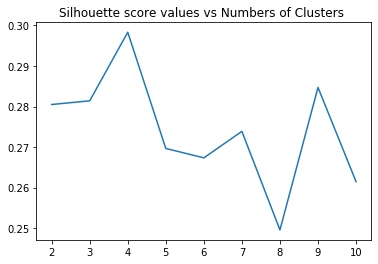

[221 219  91 989]
[-0.95927602 -0.95475113 -0.78280543 -0.6561086  -0.46153846 -0.41176471
 -0.37556561 -0.36199095 -0.31674208 -0.25791855 -0.24434389 -0.24434389
 -0.21719457 -0.17647059 -0.15837104 -0.15837104 -0.15384615 -0.13122172
 -0.13122172 -0.11312217 -0.1040724  -0.1040724 ]
HTML
CSS
Java
HTML5
JavaScript
Git
API
CSS3
SQL
Angular
Design
React
REST
PHP
Linux
AWS
[-0.79908676 -0.67123288 -0.53881279 -0.47945205 -0.39726027 -0.38812785
 -0.34703196 -0.32420091 -0.22374429 -0.18721461 -0.1826484  -0.1826484
 -0.16438356 -0.15981735 -0.15525114 -0.15525114 -0.15068493 -0.13242009
 -0.11415525 -0.11415525 -0.10045662]
REST
Git
Java
SQL
JSON
API
React
Android
Python
Angular
Development
Agile
Linux
NoSQL
JavaScript
Design
[-1. -1. -1. -1. -1. -1.]
Developer
Security
Hardware
UI
UX
Design
SQL
React
Agile
JSON
Angular
JavaScript
PHP
API
Jenkins
Docker
[-0.22244692 -0.14863498 -0.10111223]
SQL
Linux
Java
Python
Design
Windows
Development
Swift
Xcode
Developer
PHP
TCP
Agile
Database
Tes

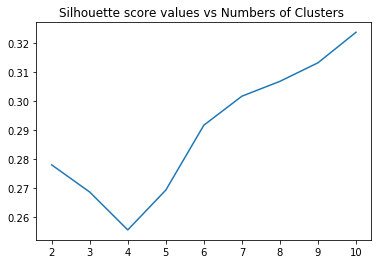

[490  58  52  30  68  12  36 103  82  58]
[]
Windows
Git
UI
CAD
Development
API
Agile
Security
TCP
Testing
REST
UX
Azure
Angular
TypeScript
Cloud
[-1.         -0.79310345 -0.22413793 -0.22413793 -0.15517241 -0.15517241
 -0.15517241 -0.13793103 -0.12068966 -0.12068966 -0.10344828 -0.10344828
 -0.10344828]
Java
SQL
Linux
JavaScript
Angular
Python
Developer
Design
PHP
Development
NoSQL
Agile
Testing
Windows
ERP
Unix
[-1.         -0.98076923]
Swift
Xcode
Python
Java
Linux
Development
Angular
Docker
Perl
CAD
UX
Selenium
Tools
JavaScript
Cassandra
TypeScript
[-1.  -0.8]
Developer
PHP
SQL
Linux
TCP
Azure
Agile
Python
OOP
Programming
Java
Development
Windows
Design
Swift
Xcode
[-1.         -0.5        -0.26470588 -0.22058824 -0.20588235 -0.19117647
 -0.11764706 -0.10294118 -0.10294118]
Python
Linux
Perl
Java
Unix
Bash
SQL
Development
Ruby
Git
Ansible
API
TCP
Docker
Cloud
Agile
[-1.         -1.         -0.66666667 -0.5        -0.5        -0.33333333
 -0.33333333 -0.33333333 -0.16666667 -0.16666

In [59]:
X = A_reduced2
optimal_clusters = find_max_silhouette_K(X, 2,11)
centroids, labels = run_K_means(X, optimal_clusters)

max_cluster = np.argmax(np.bincount(labels))
max_skill_centroid_score = np.max(centroids[max_cluster])

if len(np.where(labels==max_cluster)[0])/len(X) > 0.4 and max_skill_centroid_score < 0.3:
    print(max_cluster, len(np.where(labels==max_cluster)[0])/len(X), max_skill_centroid_score)
    optimal_clusters1 = find_max_silhouette_K(X[labels==max_cluster], 2, 11)
    centroids1, labels1 = run_K_means(X[labels==max_cluster], optimal_clusters1)

    max_cluster1 = np.argmax(np.bincount(labels1))
    max_skill_centroid_score1 = np.max(centroids1[max_cluster1])
    
    if len(np.where(labels1==max_cluster1)[0])/len(labels1) > 0.4 and max_skill_centroid_score1 < 0.3:
        print(max_cluster1, len(np.where(labels1==max_cluster1)[0])/len(labels1), max_skill_centroid_score1)
        optimal_clusters2 = find_max_silhouette_K(X[labels==max_cluster][labels1==max_cluster1], 2, 11)
        centroids2, labels2 = run_K_means(X[labels==max_cluster][labels1==max_cluster1], optimal_clusters2)

        max_cluster2 = np.argmax(np.bincount(labels2))
        max_skill_centroid_score2 = np.max(centroids2[max_cluster2])
        

### General skills recommendations

In [60]:
skills

[{'string': 'TDD', 'frequencyOfMention': '1', 'kind': 'topic'},
 {'string': 'WebApplications', 'frequencyOfMention': '1', 'kind': 'topic'},
 {'string': 'DataEngineer', 'frequencyOfMention': '2', 'kind': 'topic'},
 {'string': 'Developer', 'frequencyOfMention': '6', 'kind': 'topic'},
 {'string': 'DevOps', 'frequencyOfMention': '5', 'kind': 'topic'},
 {'string': 'Development', 'frequencyOfMention': '10', 'kind': 'topic'},
 {'string': 'CAD', 'frequencyOfMention': '1', 'kind': 'topic'},
 {'string': 'Analysis', 'frequencyOfMention': '1', 'kind': 'topic'},
 {'string': 'Visualization', 'frequencyOfMention': '1', 'kind': 'topic'},
 {'string': 'Design', 'frequencyOfMention': '6', 'kind': 'topic'},
 {'string': 'SoftwareEngineering', 'frequencyOfMention': '1', 'kind': 'topic'},
 {'string': 'VersionControl', 'frequencyOfMention': '3', 'kind': 'topic'},
 {'string': 'BuildAutomation', 'frequencyOfMention': '1', 'kind': 'topic'},
 {'string': 'FrontEnd', 'frequencyOfMention': '1', 'kind': 'topic'},
 {'

In [76]:
skills_df = pd.DataFrame(skills)
skills_df['occurences'] = np.sum(A, axis=0)

In [449]:
skills_df_db = skills_df.rename(columns={"frequencyOfMention": "frequency_of_mention"})

In [453]:
skills_df_db = skills_df_db.drop(columns=['occurences'])

In [457]:
ENGINE_STRING = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(
    'admin',
    'admin',
    'qualichain.epu.ntua.gr',
    5432,
    'api_db'
)

from sqlalchemy import create_engine
engine = create_engine(ENGINE_STRING)
skills_df_db.to_sql('clustering_skills', engine)

In [79]:
skills_df.sort_values(by='occurences', ascending=False).head(40)

,string,frequencyOfMention,kind,occurences
83,SoftwareDevelopment,2,topic,1334.0
10,SoftwareEngineering,1,topic,1334.0
52,C,4,tool,1191.0
18,ContinuousIntegration,1,topic,1181.0
90,ComputerScience,2,topic,1181.0
31,MsOffice,1,product,1084.0
94,DesignPatterns,4,topic,1034.0
2,DataEngineer,2,topic,1021.0
13,FrontEnd,1,topic,962.0
66,R,1,tool,868.0


In [72]:
skills_df.sort_values(by='frequencyOfMention', ascending=False).head(20)

,string,frequencyOfMention,kind
82,Automation,7,topic
25,Android,7,product
3,Developer,6,topic
88,Testing,6,topic
9,Design,6,topic
57,Git,6,tool
92,Database,5,topic
4,DevOps,5,topic
89,Programming,5,topic
94,DesignPatterns,4,topic


In [75]:
np.sum(A, axis=0)

array([2.500e+01, 8.260e+02, 1.021e+03, 1.590e+02, 9.100e+01, 1.780e+02,
       2.500e+01, 2.000e+01, 1.000e+00, 2.660e+02, 1.334e+03, 5.030e+02,
       8.340e+02, 9.620e+02, 9.000e+00, 2.000e+00, 8.640e+02, 8.000e+00,
       1.181e+03, 1.200e+01, 3.000e+01, 3.000e+00, 6.000e+00, 6.670e+02,
       2.100e+01, 8.600e+01, 6.500e+01, 4.800e+01, 2.190e+02, 7.900e+01,
       1.040e+02, 1.084e+03, 1.200e+01, 3.000e+00, 2.200e+01, 1.250e+02,
       1.160e+02, 3.500e+01, 4.420e+02, 1.500e+01, 8.200e+01, 6.800e+01,
       1.620e+02, 1.520e+02, 2.000e+01, 3.000e+01, 1.080e+02, 1.980e+02,
       4.700e+01, 2.800e+01, 3.910e+02, 1.410e+02, 1.191e+03, 3.000e+01,
       5.200e+01, 7.300e+01, 2.280e+02, 3.270e+02, 2.200e+02, 1.040e+02,
       6.800e+01, 5.500e+01, 3.200e+01, 8.000e+01, 1.480e+02, 2.200e+01,
       8.680e+02, 6.800e+01, 7.300e+01, 6.400e+01, 5.900e+01, 1.180e+02,
       2.030e+02, 2.430e+02, 3.000e+00, 5.500e+01, 6.700e+01, 6.000e+00,
       1.000e+01, 3.000e+00, 1.160e+02, 1.050e+02, 

In [71]:
skills[1]

{'string': 'WebApplications', 'frequencyOfMention': '1', 'kind': 'topic'}

In [70]:
skills_df.iloc[1]

string                WebApplications
frequencyOfMention                  1
kind                            topic
Name: 1, dtype: object

### Work with tokens and bigrams for better clustering

In [95]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /home/vague2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [81]:
idx_arr

array([ True,  True,  True, ...,  True, False,  True])

In [110]:
text = job_posts.requirements.iloc[0].lower()

In [111]:
tokenizer = RegexpTokenizer(r'\w+')

tokens = tokenizer.tokenize(text)

In [116]:
def jp_tokenize(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens =[]
    for w in tokens:
        if w not in stop_words: 
            filtered_tokens.append(w)
    
    return filtered_tokens

In [117]:
jp_tokenize(text)

['manage',
 'implement',
 'data',
 'science',
 'data',
 'analytics',
 'projects',
 'analyze',
 'recovery',
 'business',
 'units',
 'information',
 'needs',
 'order',
 'produce',
 'regular',
 'specialized',
 'reports',
 'design',
 'develop',
 'implement',
 'internal',
 'reporting',
 'processes',
 'conduct',
 'portfolio',
 'segmentation',
 'achieve',
 'optimal',
 'monitoring',
 'draw',
 'conclusions',
 'regarding',
 'efficiency',
 'portfolio',
 'management',
 'proceed',
 'collateral',
 'analysis',
 'focused',
 'detailed',
 'portfolio',
 'mapping',
 'manage',
 'evaluation',
 'analysis',
 'restructuring',
 'plans',
 'rearrangement',
 'methods',
 'engage',
 'sector',
 'analysis',
 'processing',
 'emphasizing',
 'particularities',
 'specific',
 'sectors',
 'actively',
 'involved',
 'npe',
 'forecasting',
 'model',
 'development',
 'implementation',
 'achieve',
 'operational',
 'targets',
 'estimation',
 'monitoring',
 'postgraduate',
 'degree',
 'quantitative',
 'discipline',
 'statistics',


In [113]:
stop_words = set(stopwords.words('english'))

filtered_tokens =[]

for w in tokens:

    if w not in stop_words: 
        filtered_tokens.append(w)
        
filtered_tokens

['manage',
 'implement',
 'data',
 'science',
 'data',
 'analytics',
 'projects',
 'analyze',
 'recovery',
 'business',
 'units',
 'information',
 'needs',
 'order',
 'produce',
 'regular',
 'specialized',
 'reports',
 'design',
 'develop',
 'implement',
 'internal',
 'reporting',
 'processes',
 'conduct',
 'portfolio',
 'segmentation',
 'achieve',
 'optimal',
 'monitoring',
 'draw',
 'conclusions',
 'regarding',
 'efficiency',
 'portfolio',
 'management',
 'proceed',
 'collateral',
 'analysis',
 'focused',
 'detailed',
 'portfolio',
 'mapping',
 'manage',
 'evaluation',
 'analysis',
 'restructuring',
 'plans',
 'rearrangement',
 'methods',
 'engage',
 'sector',
 'analysis',
 'processing',
 'emphasizing',
 'particularities',
 'specific',
 'sectors',
 'actively',
 'involved',
 'npe',
 'forecasting',
 'model',
 'development',
 'implementation',
 'achieve',
 'operational',
 'targets',
 'estimation',
 'monitoring',
 'postgraduate',
 'degree',
 'quantitative',
 'discipline',
 'statistics',


In [114]:
bigrams = nltk.bigrams(filtered_tokens)

In [115]:
print(*map(' '.join, bigrams), sep=', ')

manage implement, implement data, data science, science data, data analytics, analytics projects, projects analyze, analyze recovery, recovery business, business units, units information, information needs, needs order, order produce, produce regular, regular specialized, specialized reports, reports design, design develop, develop implement, implement internal, internal reporting, reporting processes, processes conduct, conduct portfolio, portfolio segmentation, segmentation achieve, achieve optimal, optimal monitoring, monitoring draw, draw conclusions, conclusions regarding, regarding efficiency, efficiency portfolio, portfolio management, management proceed, proceed collateral, collateral analysis, analysis focused, focused detailed, detailed portfolio, portfolio mapping, mapping manage, manage evaluation, evaluation analysis, analysis restructuring, restructuring plans, plans rearrangement, rearrangement methods, methods engage, engage sector, sector analysis, analysis processing,

In [127]:
A_nltk = np.zeros((len(job_posts), len(skills)))

idx = 0
for s in skills:
    skl = s['string']
#     idx_arr = pd.Index(job_posts.requirements).str.contains(skl, regex=False)
#     jp_index = 0
    for jp_idx in range(len(job_posts)):
        jp_reqs = job_posts.requirements.iloc[jp_idx] 
        filtered_tokens = jp_tokenize(jp_reqs)
        for t in filtered_tokens:
            if skl.lower()==t.lower():
                A_nltk[jp_idx][idx] = 1
                break
        if A_nltk[jp_idx][idx] == 0:
            bigrams = nltk.bigrams(filtered_tokens)
            skls = camel_case_split(skl)
            if len(skls)>1:
                bigram = skls[0]+' ' +skls[1]
                for b in bigrams:
                    b_str = b[0]+ b[1]
                    if bigram.lower()==b_str.lower():
                        A_nltk[jp_idx][idx] = 1
                        break
    idx+=1


print(A_nltk)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [128]:
np.sum(A_nltk, axis=0)

array([ 25.,   0.,   0., 193.,  97., 711.,   8., 147.,  16., 462.,   0.,
         0.,   0.,  26.,  23.,  61.,   0.,  71.,   0.,  73., 405.,  13.,
        33.,  81.,  21.,  86.,  65.,  66., 224.,  85., 137.,   0.,  12.,
       133.,  23., 107., 118.,  65., 287.,  15.,  82.,  68., 268.,  83.,
       128.,  59., 109., 210., 138.,  36., 209., 137., 293.,  31.,  53.,
        72., 101., 409., 161., 104.,  73.,  56.,  33.,  80., 148.,  37.,
        78.,  69.,  76.,  65.,  58., 120., 102., 209.,   3.,  56.,  68.,
         6.,  10.,   5., 234., 140., 153.,   0., 211.,  92.,  45.,   0.,
       294., 313.,   0., 167., 140.,  33.,   0.])

In [132]:
skills_df['occurences'] = np.sum(A_nltk, axis=0)

In [148]:
skills_df.sort_values(by='occurences', ascending=False).head(40)

,string,frequencyOfMention,kind,occurences
5,Development,10,topic,711.0
9,Design,6,topic,462.0
57,Git,6,tool,409.0
20,Tools,1,topic,405.0
89,Programming,5,topic,313.0
88,Testing,6,topic,294.0
52,C,4,tool,293.0
38,SQL,4,tool,287.0
42,JavaScript,3,tool,268.0
80,Security,3,topic,234.0


In [142]:
A_nltk_reduced = A_nltk[np.sum(A, axis=1)>0]
A_nltk_reduced.shape

nltk_reduced_skill_indices = np.where(np.sum(A_nltk_reduced, axis=0)<500)[0]

A_nltk_reduced2 = A_nltk_reduced[:,(np.sum(A_nltk_reduced, axis=0)<500)]
print(A_nltk_reduced2.shape)
print(nltk_reduced_skill_indices)

(1568, 94)
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]


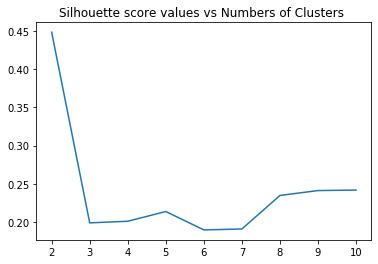

[1521   47]
[-0.30309007 -0.23800131 -0.23537147 -0.19329389 -0.18869165 -0.17619987
 -0.17488494 -0.16239316 -0.14727153 -0.1374096  -0.1374096  -0.1268902
 -0.12294543 -0.10979619 -0.1078238  -0.10716634 -0.10585141]
Design
Git
Tools
Testing
SQL
JavaScript
Programming
C
Linux
REST
Java
Developer
Security
UI
Agile
Python
[-1.        -1.        -1.        -1.        -1.        -1.
 -1.        -1.        -1.        -1.        -1.        -1.
 -1.        -1.        -1.        -1.        -1.        -1.
 -1.        -0.9787234 -0.9787234 -0.9787234 -0.9787234 -0.9787234]
Maven
Orchestration
Jenkins
Gradle
Scala
NoSQL
Storage
Kafka
Cassandra
DevOps
Agile
Python
Git
GO
R
Tools
0 0.9700255102040817 0.3030900723208411


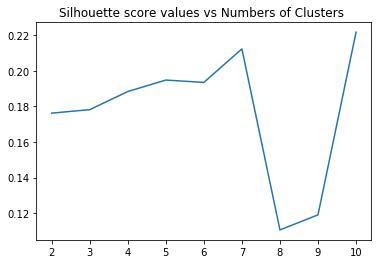

[636  65  97  33 188 189 105  58  91  59]
[-0.14622642 -0.12578616 -0.11163522 -0.10220126]
Design
Git
Tools
Marketing
Linux
Testing
Analysis
Developer
Windows
PHP
Programming
Agile
TCP
Security
Hardware
C
[-0.96923077 -0.93846154 -0.92307692 -0.90769231 -0.8        -0.16923077
 -0.13846154]
Android
Git
REST
JSON
IOS
Java
Design
HTTP
Agile
C
Programming
Swift
UX
API
Testing
Maven
[-0.93814433 -0.89690722 -0.75257732 -0.48453608 -0.44329897 -0.27835052
 -0.24742268 -0.2371134  -0.2371134  -0.22680412 -0.20618557 -0.19587629
 -0.18556701 -0.17525773 -0.17525773 -0.17525773 -0.17525773 -0.17525773
 -0.16494845 -0.1443299  -0.13402062 -0.13402062 -0.12371134 -0.11340206
 -0.11340206 -0.10309278]
CSS
HTML
JavaScript
Design
SQL
PHP
Java
Programming
C
HTML5
Tools
Git
Database
Agile
UI
Testing
[-1. -1. -1. -1. -1. -1. -1. -1. -1.]
AWS
JavaScript
Docker
CSS
HTML5
Git
REST
Design
API
Tools
Testing
Java
Programming
Analysis
CSS3
IOS
[-0.92553191 -0.37234043 -0.29787234 -0.29787234 -0.27659574 -0.

In [211]:
X = A_nltk_reduced2
optimal_clusters = find_max_silhouette_K(X, 2,11)
centroids, labels = run_K_means(X, optimal_clusters, nltk_reduced_skill_indices)

max_cluster = np.argmax(np.bincount(labels))
max_skill_centroid_score = np.max(centroids[max_cluster])

if len(np.where(labels==max_cluster)[0])/len(X) > 0.4 and max_skill_centroid_score < 0.4:
    print(max_cluster, len(np.where(labels==max_cluster)[0])/len(X), max_skill_centroid_score)
    optimal_clusters1 = find_max_silhouette_K(X[labels==max_cluster], 2, 11)
    centroids1, labels1 = run_K_means(X[labels==max_cluster], optimal_clusters1, nltk_reduced_skill_indices)

    max_cluster1 = np.argmax(np.bincount(labels1))
    max_skill_centroid_score1 = np.max(centroids1[max_cluster1])
    
        

In [151]:
!pip install sqldf
import sqldf

In [159]:
skills_df = skills_df.rename(columns={"string": "skill"})

#### Top 10 topics

In [160]:
sqldf.run("select skill from skills_df where kind = 'topic' order by occurences desc limit 10")

,skill
0,Development
1,Design
2,Tools
3,Programming
4,Testing
5,Security
6,Agile
7,Developer
8,UI
9,Automation


#### Top 10 tools

In [161]:
sqldf.run("select skill from skills_df where kind = 'tool' order by occurences desc limit 10")

,skill
0,Git
1,C
2,SQL
3,JavaScript
4,Python
5,Java
6,REST
7,CSS
8,HTML5
9,Akka


#### Top 10 products

In [162]:
sqldf.run("select skill from skills_df where kind = 'product' order by occurences desc limit 10")

,skill
0,Linux
1,Docker
2,IOS
3,JSON
4,Angular
5,Android
6,Windows
7,GO
8,Unix
9,Cassandra


#### Simple Courses recommendation

In [167]:
import psycopg2

In [168]:
host='qualichain.epu.ntua.gr'
database='api_db'
user='admin'
password='admin'
port='5432'

In [179]:
conn = psycopg2.connect(host=host, dbname=database, user=user, password=password, port=port)

cur = conn.cursor()
        
query = """select c.course_title
    from curriculum_designer_skill s
    inner join curriculum_designer_course_course_skills cs
    on s.id = cs.skill_id
    inner join curriculum_designer_course c
    on c.id = cs.course_id
    where lower(skill_title) Like '%java%' limit 5;"""
cur.execute(query)

rec_courses = cur.fetchall()
cur.close()

In [180]:
rec_courses

[('Multimedia Technology',),
 ('Computer System Performance',),
 ('Distributed Systems',),
 ('Programming Languages I',),
 ('Software Engineering',)]

### Add labels to all the job posts according to the previous analysis

In [184]:
job_posts['label'] = 0

In [185]:
job_posts

,requirements,label
0,Manage and implement Data Science / Data Analy...,0
1,Develop internal data solutions to track key a...,0
2,"Design, build, test and maintain our configura...",0
3,"Work with development leads, software engineer...",0
4,Απαραίτητα Προσόντα Απαραίτητη πολύ καλή γνώ...,0
...,...,...
1772,Benefits: Reference ID: helios engineer Job Ty...,0
1773,"To keep pace with this fast-changing world, AK...",0
1774,Demonstrable previous experience (at least 2 y...,0
1775,Γνώση τουχάλιστον ενός γνωστού framework (Angu...,0


In [186]:
labels==1

array([False, False, False, ..., False, False, False])

In [189]:
lbls = np.zeros(1568) 

In [190]:
lbls

array([0., 0., 0., ..., 0., 0., 0.])

In [191]:
lbls[labels==1] = 1

In [259]:
lbls0 = np.where(labels==0)[0]

In [288]:
class2_indices = np.where(labels1==1)[0]
idxs = lbls0[class2_indices]
lbls[idxs] = 2

In [291]:
class3_indices = np.where(labels1==2)[0]
idxs = lbls0[class3_indices]
lbls[idxs] = 3

In [292]:
class4_indices = np.where(labels1==3)[0]
idxs = lbls0[class4_indices]
lbls[idxs] = 4

In [293]:
class5_indices = np.where(labels1==4)[0]
idxs = lbls0[class5_indices]
lbls[idxs] = 5

In [294]:
class6_indices = np.where(labels1==5)[0]
idxs = lbls0[class6_indices]
lbls[idxs] = 6

In [295]:
class7_indices = np.where(labels1==6)[0]
idxs = lbls0[class7_indices]
lbls[idxs] = 7

In [296]:
class8_indices = np.where(labels1==7)[0]
idxs = lbls0[class8_indices]
lbls[idxs] = 8

In [297]:
class9_indices = np.where(labels1==8)[0]
idxs = lbls0[class9_indices]
lbls[idxs] = 9

In [298]:
class10_indices = np.where(labels1==9)[0]
idxs = lbls0[class10_indices]
lbls[idxs] = 10

In [299]:
lbls

array([5., 5., 6., ..., 8., 0., 7.])

In [301]:
job_posts

,requirements,label
0,Manage and implement Data Science / Data Analy...,0
1,Develop internal data solutions to track key a...,0
2,"Design, build, test and maintain our configura...",0
3,"Work with development leads, software engineer...",0
4,Απαραίτητα Προσόντα Απαραίτητη πολύ καλή γνώ...,0
...,...,...
1772,Benefits: Reference ID: helios engineer Job Ty...,0
1773,"To keep pace with this fast-changing world, AK...",0
1774,Demonstrable previous experience (at least 2 y...,0
1775,Γνώση τουχάλιστον ενός γνωστού framework (Angu...,0


In [304]:
for i in range(11):
    print(np.where(lbls==i)[0].shape)

(636,)
(47,)
(65,)
(97,)
(33,)
(188,)
(189,)
(105,)
(58,)
(91,)
(59,)


In [311]:
reduced_A_indices = np.where(np.sum(A, axis=1)>0)[0]

In [308]:
all_labels = np.zeros(len(A))

In [312]:
all_labels[reduced_A_indices] = lbls

In [314]:
all_labels.shape

(1777,)

In [337]:
job_posts['label'] = all_labels

In [413]:
job_posts

,requirements,label_title,label
0,Manage and implement Data Science / Data Analy...,SQL Developer,5.0
1,Develop internal data solutions to track key a...,SQL Developer,5.0
2,"Design, build, test and maintain our configura...",Operations Engineer,6.0
3,"Work with development leads, software engineer...",Operations Engineer,6.0
4,Απαραίτητα Προσόντα Απαραίτητη πολύ καλή γνώ...,SQL Developer,5.0
...,...,...,...
1772,Benefits: Reference ID: helios engineer Job Ty...,Software Engineer,0.0
1773,"To keep pace with this fast-changing world, AK...",Security Engineer,9.0
1774,Demonstrable previous experience (at least 2 y...,BackEnd Engineer,8.0
1775,Γνώση τουχάλιστον ενός γνωστού framework (Angu...,Software Engineer,0.0


In [328]:
job_posts['label_title'] = 'Software Engineer'

In [345]:
def get_label_title(row):
    label_dict = {0:'Software Engineer', 
                  1: 'DevOps Engineer', 
                  2: 'Mobile Developer (Android, IOS)', 
                  3:'FrontEnd Designer',
                  4: 'Web Developer (Front End)',
                  5: 'SQL Developer',
                  6: 'Operations Engineer',
                  7: 'Front End Engineer (JS)',
                  8: 'BackEnd Engineer',
                  9: 'Security Engineer',
                  10: 'Mobile Developer (Swift, IOS, XCode)'
                }
    
    num = int(row['label'])
    return label_dict[num]

In [347]:
job_posts['label_title'] = job_posts.apply(lambda row: get_label_title(row), axis=1)

In [348]:
job_posts

,requirements,label_title,label
0,Manage and implement Data Science / Data Analy...,SQL Developer,5.0
1,Develop internal data solutions to track key a...,SQL Developer,5.0
2,"Design, build, test and maintain our configura...",Operations Engineer,6.0
3,"Work with development leads, software engineer...",Operations Engineer,6.0
4,Απαραίτητα Προσόντα Απαραίτητη πολύ καλή γνώ...,SQL Developer,5.0
...,...,...,...
1772,Benefits: Reference ID: helios engineer Job Ty...,Software Engineer,0.0
1773,"To keep pace with this fast-changing world, AK...",Security Engineer,9.0
1774,Demonstrable previous experience (at least 2 y...,BackEnd Engineer,8.0
1775,Γνώση τουχάλιστον ενός γνωστού framework (Angu...,Software Engineer,0.0


### Recommendations based on the user's profile

In [357]:
CV_json = """{
   "PersonURI":"http://somewhere/JohnSmith",
   "Label":"CV1",
   "targetSector":"IT",
   "expectedSalary":"40K",
   "Description":"It is a test CV",
   "Skills":[
      {
         "SkillLabel":"Java",
         "proficiencyLevel":"basic",
         "SkillComment":"java programming language"
      
},
      {
         "SkillLabel":"SQL",
         "proficiencyLevel":"basic",
         "SkillComment":"sql"
      
}
   
],
   "workHistory":[
      {
         "position":"developer",
         "from":"2019-01-01",
         "to":"2020-01-01",
         "employer":"QualiChain"
      
}
   
],
   "Education":[
      {
         "title":"informatic engineering",
         "from":"2015-09-01",
         "to":"2019-01-01",
         "organisation":"a",
         "description":"a"
      
}
   
]
}"""

In [358]:
CV = json.loads(CV_json)

In [359]:
CV['Skills']

[{'SkillLabel': 'Java',
  'proficiencyLevel': 'basic',
  'SkillComment': 'java programming language'},
 {'SkillLabel': 'SQL', 'proficiencyLevel': 'basic', 'SkillComment': 'sql'}]

In [367]:
X_pred = np.zeros(94)

for s in CV['Skills']:
    skill = s['SkillLabel']
    skl_idx = skill_index_dict[skill]
    skl_reduced_idx = np.where(nltk_reduced_skill_indices==skill_index_dict[skill])
    X_pred[skl_reduced_idx] = 1 

In [475]:
np.where(nltk_reduced_skill_indices==skill_index_dict['Java'])

(array([49]),)

In [477]:
skill_index_dict['SQL']

38

In [368]:
X_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [392]:
all_centroids = []


In [396]:
centroid0 = centroids1[0]
centroid1 = centroids[1]
centroids2 = centroids1[1:]

In [398]:
all_centroids = np.vstack([centroid0,centroid1])
all_centroids = np.vstack([all_centroids, centroids2])

In [480]:
all_centroids.shape[1]

94

### Classify the CV using cosine distance

In [409]:
from scipy import spatial

distance_vec = np.zeros(11)

i = 0
for c in all_centroids:
    distance_vec[i] = spatial.distance.cosine(c, X_pred)
    print(distance_vec[i])
    i+=1

0.9419233959107803
1.0
0.9363929799418782
0.7374708118162742
1.0
0.34154770366760934
0.8301333741637125
0.8895699702568823
0.6560798420737809
1.0
0.9876278928983624


In [411]:
top3_categories = np.argsort(distance_vec)[0:3]

In [412]:
top3_categories

array([5, 8, 3])

In [429]:
print(job_posts['label_title'][job_posts['label']==top3_categories[0]].iloc[0])
print(job_posts['label_title'][job_posts['label']==top3_categories[1]].iloc[0])
print(job_posts['label_title'][job_posts['label']==top3_categories[2]].iloc[0])

SQL Developer
BackEnd Engineer
FrontEnd Designer


In [483]:
centroid_label = {}
for idx in range(len(all_centroids)):
    centroid_label[idx] = job_posts['label_title'][job_posts['label']== idx].iloc[0]
print(centroid_label)

{0: 'Software Engineer', 1: 'DevOps Engineer', 2: 'Mobile Developer (Android, IOS)', 3: 'FrontEnd Designer', 4: 'Web Developer (Front End)', 5: 'SQL Developer', 6: 'Operations Engineer', 7: 'Front End Engineer (JS)', 8: 'BackEnd Engineer', 9: 'Security Engineer', 10: 'Mobile Developer (Swift, IOS, XCode)'}


In [437]:
for t in top3_categories:
    print("Category: ", t)
    centr = all_centroids[t]
#     print(np.sort(-centr[centr>0.1]))
    for sk in np.argsort(-centr)[0:10]:
        skl = skills[nltk_reduced_skill_indices[sk]]['string']
        skill_exists = False
        for cv_sk in CV['Skills']:
            if skl == cv_sk['SkillLabel']:
                skill_exists = True
#                 print("skill exists")
                break
        if not skill_exists:
            print(skills[nltk_reduced_skill_indices[sk]]['string'])

Category:  5
Design
Tools
Database
Programming
Analysis
Testing
C
REST
Category:  8
Git
Tools
Python
Jenkins
Agile
Linux
Cloud
Programming
Category:  3
CSS
HTML
JavaScript
Design
PHP
Programming
C
HTML5


### Recommend courses based on profile

In [445]:
skill = 'html'
conn = psycopg2.connect(host=host, dbname=database, user=user, password=password, port=port)

cur = conn.cursor()
        
query = """select c.course_title
    from curriculum_designer_skill s
    inner join curriculum_designer_course_course_skills cs
    on s.id = cs.skill_id
    inner join curriculum_designer_course c
    on c.id = cs.course_id
    where lower(skill_title) Like '%s' limit 5;"""
cur.execute(query % skill)

rec_courses = cur.fetchall()
cur.close()

In [446]:
rec_courses

[('Databases',), ('Internet Programming',)]

In [459]:
all_centroids.shape

(11, 94)

In [460]:
np.save('software_job_posts_centroids.npy', all_centroids)

In [461]:
nltk_reduced_skill_indices

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94])

In [464]:
idx_to_skill_dict = {}
skill_to_idx_dict = {}
for sk in range(94):
    idx_to_skill_dict[sk] = skills[nltk_reduced_skill_indices[sk]]['string']
    skill_to_idx_dict[skills[nltk_reduced_skill_indices[sk]]['string']] = sk

In [471]:
skill_to_idx_dict
# idx_to_skill_dict

{'TDD': 0,
 'WebApplications': 1,
 'DataEngineer': 2,
 'Developer': 3,
 'DevOps': 4,
 'CAD': 5,
 'Analysis': 6,
 'Visualization': 7,
 'Design': 8,
 'SoftwareEngineering': 9,
 'VersionControl': 10,
 'BuildAutomation': 11,
 'FrontEnd': 12,
 'Microservices': 13,
 'Orchestration': 14,
 'RelationalDatabase': 15,
 'Storage': 16,
 'ContinuousIntegration': 17,
 'Marketing': 18,
 'Tools': 19,
 'WebServices': 20,
 'Backend': 21,
 'GO': 22,
 'IIS': 23,
 'Android': 24,
 'Cassandra': 25,
 'Unix': 26,
 'Linux': 27,
 'Windows': 28,
 'Docker': 29,
 'MsOffice': 30,
 'Debian': 31,
 'IOS': 32,
 'ERP': 33,
 'Angular': 34,
 'JSON': 35,
 'Jira': 36,
 'SQL': 37,
 'ETL': 38,
 'AWS': 39,
 'Azure': 40,
 'JavaScript': 41,
 'React': 42,
 'Scripting': 43,
 'Bash': 44,
 'PHP': 45,
 'Python': 46,
 'Akka': 47,
 'Perl': 48,
 'Java': 49,
 'UX': 50,
 'C': 51,
 'Selenium': 52,
 'HTTP': 53,
 'TCP': 54,
 'HTML': 55,
 'Git': 56,
 'CSS': 57,
 'Jenkins': 58,
 'Maven': 59,
 'Gradle': 60,
 'PostgreSQL': 61,
 'CSS3': 62,
 'HTML5

In [484]:
import json

json_str = json.dumps(idx_to_skill_dict)
f = open("idx_to_skill_dict.json","w")
f.write(json_str)
f.close()

json_str = json.dumps(skill_to_idx_dict)
f = open("skill_to_idx_dict.json","w")
f.write(json_str)
f.close()

json_str = json.dumps(centroid_label)
f = open("centroid_labels.json","w")
f.write(json_str)
f.close()